In [38]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_retrieval, pairs_from_exhaustive

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [39]:
images = Path('datasets/Khachkar/images/')

outputs = Path('outputs/Khachkar/')
sfm_pairs = outputs / 'pairs-netvlad.txt'
sfm_dir = outputs / 'sfm_superpoint+superglue'

retrieval_conf = extract_features.confs['netvlad']
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data and refined with SfM.

In [40]:
if not images.exists():
    !wget http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip -P datasets/
    !unzip -q datasets/South-Building.zip -d datasets/

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the most similar ones. For smaller dataset we can instead use exhaustive matching via `hloc/pairs_from_exhaustive.py`, which would find $\frac{n(n-1)}{2}$ images pairs.

In [41]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_exhaustive.main(sfm_pairs, features=retrieval_path)

[2022/06/19 19:30:16 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2022/06/19 19:30:16 hloc INFO] Found 148 images in root datasets/Khachkar/images.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:08<00:00, 16.94it/s]
[2022/06/19 19:30:30 hloc INFO] Finished exporting features.
[2022/06/19 19:30:30 hloc INFO] Found 10878 pairs.


## Extract and match local features

In [42]:
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

[2022/06/19 19:30:30 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2022/06/19 19:30:30 hloc INFO] Found 148 images in root datasets/Khachkar/images.


Loaded SuperPoint model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:05<00:00, 26.92it/s]
[2022/06/19 19:30:35 hloc INFO] Finished exporting features.
[2022/06/19 19:30:35 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10878/10878 [15:42<00:00, 11.54it/s]
[2022/06/19 19:46:18 hloc INFO] Finished exporting matches.


## 3D reconstruction
Run COLMAP on the features and matches.

In [43]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

[2022/06/19 19:46:18 hloc INFO] Creating an empty database...
[2022/06/19 19:46:19 hloc INFO] Importing images into the database...
[2022/06/19 19:46:25 hloc INFO] Importing features into the database...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 2409.27it/s]
[2022/06/19 19:46:25 hloc INFO] Importing matches into the database...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10878/10878 [00:06<00:00, 1580.51it/s]
[2022/06/19 19:46:32 hloc INFO] Performing geometric verification of the matches...
[2022/06/19 19:50:12 hloc INFO] Running 3D reconstruction...
W0619 19:51:40.433918 143059 levenberg_marquardt_strategy.cc:114] Linear solver failure. Failed to compute a step: CHOLMOD warning: Matrix not positive definite.
W0619 19:5

## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

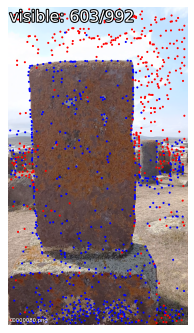

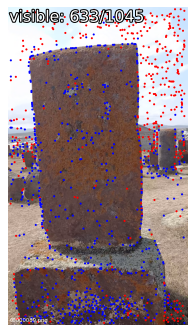

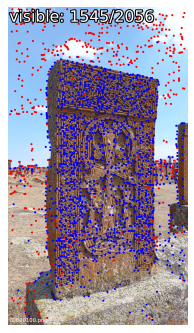

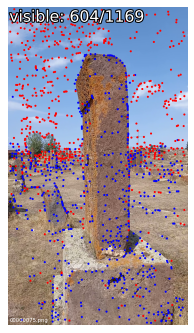

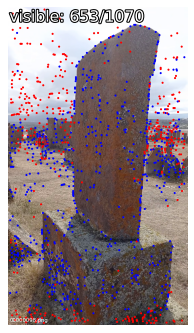

In [44]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=5)

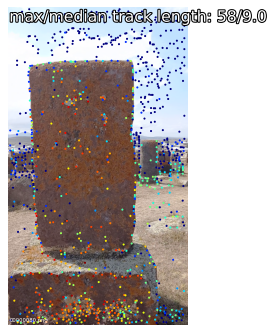

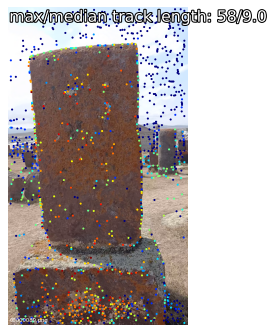

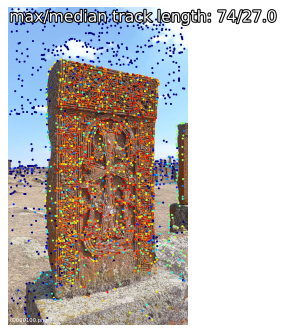

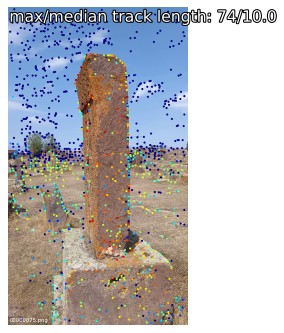

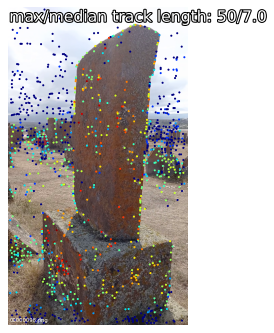

In [45]:
visualization.visualize_sfm_2d(model, images, color_by='track_length', n=5)

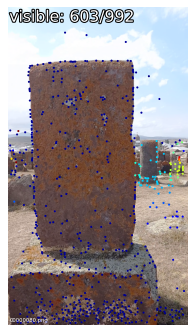

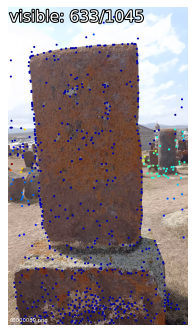

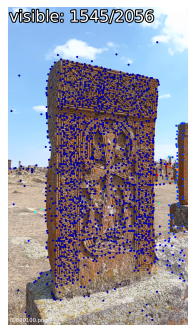

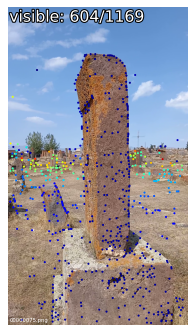

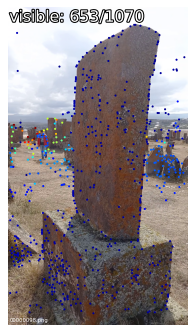

In [46]:
visualization.visualize_sfm_2d(model, images, color_by='depth', n=5)